In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with maximum likelihood quantum amplitude estimation

In this notebook, we show an approach to quantum amplitude estimation (QAE) that does not use quantum phase estimation (QPE). This implementation of QAE, called maximum likelihood quantum amplitude estimation (MLQAE), reduces the complexity of the quantum circuits and makes it less expensive for near-term quantum devices. The contents of this notebook are outlined below: 

1. Learn background of the conventional QAE algorithm.   
2. Build the components of the maximum likelihood quantum amplitude estimation (MLQAE) algorithm.<sup>1<sup>
2. Demonstrate a toy example of an integration performed using the MLQAE technique.<sup>2<sup>    

### Background
The QAE algorithm is designed to find an estimate for the amplitude $a \in [0,1]$ of the state $\vert\psi_1\rangle$ given a unitary operator $A$ acting on $n+1$ qubits<sup>3</sup>:
$$A\vert0\rangle_n \vert0\rangle= \sqrt(1-a)\vert\psi_0\rangle_n \vert0\rangle+ \sqrt(a)\vert\psi_1\rangle_n\vert1\rangle.$$
    
To find the amplitude of the state $\vert\psi_1\rangle_n$, the conventional QAE algorithm uses the Grover operator:
$$Q = AS_{0}A^{\dagger}S_{\psi_1},$$
where $S_0$ and $S_1$ are reflections about the $|\psi_0\rangle$ and $|\psi_1\rangle$ states, respectively, in combination with QPE.<sup>4</sup> The QPE is used after amplitude amplification by the Grover operator to extract an estimate for the amplitude. It is important to note here that the QPE makes the conventional QAE algorithm expensive for near-term quantum devices.<sup>1,2</sup> Qiskit offers a QAE module called `AmplitudeEstimation`, which uses the Qiskit `QPE` module as well.<sup>5</sup>


### The MLQAE algorithm

The MLQAE is a variant of QAE that does not use the QPE and achieves nearly the optimal quantum speedup with a reasonable circuit length. 

To understand the algorithm, we first consider an $n$-qubit system and the unitary operator $A$ acting on $n+1$ qubits:

$$|\psi\rangle = A |0\rangle_{n} |0\rangle = \sqrt(1 - a) |\psi_{0}\rangle_{n} |0\rangle + \sqrt(a) |\psi_{1}\rangle_{n} |1\rangle,$$

where $|\psi_{1}\rangle_{n}$ is the good state and $|\psi_{0}\rangle_{n}$ is the bad state. The main goal, finding the value of $a \in [0,1]$, remains the same as in conventional QAE. 

The MLQAE algorithm can be broken down into the following steps:

1. Create quantum circuits with different numbers of amplitude amplification operations. 
2. Create an individual likelihood function for all the quantum circuits.
3. Combine all the likelihood functions into a single likelihood function.
4. Estimate the amplitude by finding the maximum likelihood of the combined likelihood function. 

#### Amplify a state using an amplitude amplification operator

The first step is to amplify $|\psi\rangle$ using a Grover amplitude amplification operator $Q = AS_{0}A^{-1}S_{\chi}$. Unlike Grover’s search, the algorithm is used to search for multiple solutions, where we define $S_{0} = I_{n+1} - 2|0\rangle_{n+1}\langle0|_{n+1}$ and $S_{\chi} = (\otimes^nI_2)\otimes Z$. The $S_{\chi}$ adds a negative sign to the good state, $|\psi_{1}\rangle_{n}$, and does nothing to the bad state, $|\psi_{0}\rangle_{n}$. 

Furthermore, let us define a parameter $\theta \in [0,\pi/2]$ so that $sin^2\theta$ = $a$. With this, we can rewrite

$$|\psi\rangle =A |0\rangle_{n} |0\rangle = cos(\theta) |\psi_{0}\rangle_{n} |0\rangle + sin(\theta) |\psi_{1}\rangle_{n} |1\rangle.$$

Let us then apply the amplitude amplification unitary operator $Q$ on $|\psi\rangle$ a total of $k$ number of times so that we get:

$$Q^{k} |\psi\rangle = cos((2k + 1)\theta) |\psi_{0}\rangle |0\rangle + sin((2k + 1)\theta) |\psi_{1}\rangle |1\rangle.$$

The final equation shows a quadratically larger probability of obtaining the good states than measuring $A |0\rangle_{n} |0\rangle$ directly provided. The $\theta$ is sufficiently small so that $(2m + 1)\theta \leq \pi/2$.<sup>3</sup>

#### Create individual likelihood functions

The next step is to create the likelihood function, which is generally used to evaluate the value of a parameter based on the probability distribution of some variable. In this particular algorithm, we create the likelihood function for all different circuits $(L_{k}(h_{k};\theta))$ and find the maxima of the likelihood function for all the circuits. Notice that the different levels of amplification $(Q^1, Q^2, ...,Q^k)$ are executable independently, which allows the MLQAE algorithm to compute this in parallel, as shown in the figure below.<sup>2</sup> 

<img src="Fig.PNG"  width="60%" height="60%">

#### Combine individual likelihood functions
After creating the individual likelihood functions $L_{k}(h_{k};\theta)$, we combine them into one single likelihood function $L(h;\theta)$, which is obtained by:

$$L(h;\theta)= \prod_{k=0}^{M}L_k(h_k;\theta).$$

#### Find the maximum likelihood and estimate the amplitude

Finally, we estimate the amplitude $a$ by applying the maximum likelihood method to the single likelihood function. We take the logarithm of the single likelihood function and apply the $\arg\max _{\theta}$ to obtain an estimate:

$$\hat{\theta}= \arg\max _{\theta} \space ln(L(h;\theta)).$$

The estimate for the amplitude $\hat{a}$ is obtained through $\hat{a}:=sin^2(\hat{\theta})$.

### Toy example: Numerical integration using MLQAE

In this section, we demonstrate the MLQAE algorithm through a toy example where we numerically integrate the following function:

$$ \int_{0}^{\pi/4} sin^2 x \,dx, $$
where the function $sin^2 x$ is a function of $x\in[0,\pi/4]$. To solve the integral numerically, we use the Riemann sum over the integral and obtain the following:

$$ \int_{0}^{\pi/4} sin^2 x \,dx  \approx \sum_{i=0}^{3} sin^2 x_i^*  \frac{\pi/4}{4},$$ 

where $x_i^*$ is the midpoint of the subinterval and is defined as $x_i^* = \frac{i+1/2}{4} \frac{\pi}{4}$ (see figure below). As can be seen from the equation, the interval of the Riemann sum is divided into four subintervals of equal width. For a detailed derivation of this approximation, refer to Pooja et al. 2020.<sup>2</sup> 


<img src="Fig-2.PNG"  width="60%" height="60%">

In this example, we have the midpoints ${x}^*$ $\in$ $\{\frac{\pi}{32}$, $\frac{3\pi}{32}$, $\frac{5\pi}{32}$,  $\frac{7\pi}{32} \}$, as indicated in the figure. Writing out the Riemann sum of our problem, we obtain:

$$ \int_{0}^{\pi/4} sin^2 x \,dx \approx \sum_{i=0}^{3} sin^2 x_i^* \frac{\pi/4}{4} = (sin^2(\frac{1}{8}.\frac{\pi}{4}) + sin^2(\frac{3}{8}.\frac{\pi}{4}) + sin^2(\frac{5}{8}.\frac{\pi}{4}) + sin^2(\frac{7}{8}.\frac{\pi}{4}))*\frac{\pi/4}{4} \approx 0.141085.$$




#### Construction of the circuits

In this section, we will demonstrate how to compute this result of the Riemann sum using the MLQAE algorithm. To obtain the solution to our numerical intergration problem, we perform the following steps:
1. Import the necessary packages.
2. Construct the operator $A$.
3. Construct the operator $Q$.
4. Construct the maximum likelihood functions.
5. Execute the quantum circuit and obtain our solution. 

##### Packages

We start by importing some useful packages from Qiskit.

In [2]:
# Standard packages
import numpy as np
import math

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

import warnings
warnings.filterwarnings('ignore')

# Backend Configuration
# Configure backend, using the qasm simulator
simulator = Aer.get_backend('qasm_simulator')

##### Operator $A$

In the code below, we construct a function for operator $A$. The following state is obtained when we apply the operator $A$ to an $n$-qubit system:

$$ \vert \Psi \rangle = A\vert 0\rangle_n\vert0\rangle=\sum_{i=0}^{2^n-1}\frac{1}{\sqrt{2^n}}\vert i\rangle_n( cos(\theta) |0\rangle + sin(\theta) |1\rangle).$$

The operator $A$ is implemented using the upper bound of the integral, $\pi/4$, as shown in the function `operatorA` in the code cell below. The value of the phases is $\frac{\pi/4}{2^{(qubit no. -1)}},$ which is derived from the number of qubits $qubit no.$ and the value of the upper bound of the integral.

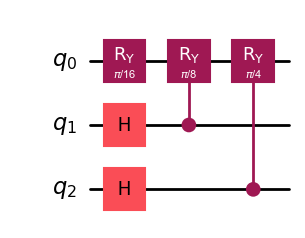

In [3]:
# Prepare the unitary operator A
def operatorA(n, b):
        
        qc = QuantumCircuit(n, name = 'A')
        
        qc.h(range(1,n))
        qc.ry((b/(pow(2, n-1))), 0)
        
        for qubitNo in range(1,n):
            qc.cry((b/(pow(2, n-1-qubitNo))), qubitNo, 0)
            
        return qc

#draw operator A for a 3-qubit system 
operatorA(3, np.pi/4).draw('mpl')

##### Operator $Q$

Next, we construct the operator $Q = AS_{0}A^{\dagger}S_{\chi}$. 
We start by writing functions for the sub-operators $A^{\dagger}$, $S_{0}$, and $S_{\chi}$ before then combining them and constructing $Q$.  

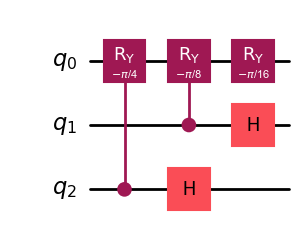

In [4]:
# Prepare the conjugate of unitary operator A
def operatorAbar(n, b):
        
        qc = QuantumCircuit(n, name = 'Abar')
        
        for qubitNoTemp in range(1,n):
            qubitNo = n - qubitNoTemp
            qc.cry((-b/(pow(2, n-1-qubitNo))), qubitNo, 0)
        
        qc.ry((-b/(pow(2, n-1))), 0)
        qc.h(range(1,n))
        
        return qc
    
operatorAbar(3, np.pi/4).draw('mpl')

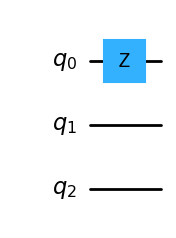

In [5]:
# Prepare the unitary operator S_{x}
def operatorSx(n):
    qc = QuantumCircuit(n, name = 'Sx')
    qc.z(0)
    return qc

operatorSx(3).draw('mpl')

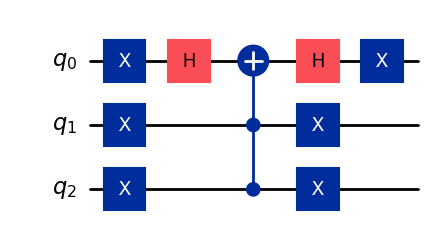

In [6]:
# Prepare the unitary operator S_{0}
def operatorS0(n):
    qc = QuantumCircuit(n, name = 'S0')
    qc.x(range(n))
    qc.h(0)
    qc.mcx(list(range(1,n)), 0)
    qc.h(0)
    qc.x(range(n))
    return qc

operatorS0(3).draw('mpl')

Then, we combine all the operators to build $Q$ for the problem below:

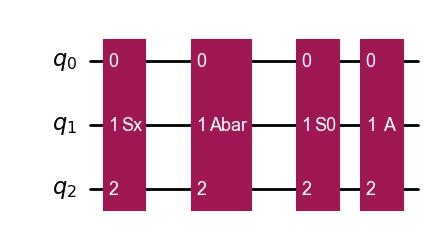

In [7]:
# Prepare the unitary operator Q = AS_{0}A^{-1}S_{x}
def operatorQ(n, b):
    
    qc = QuantumCircuit(n, name = 'Q')
    qc.append(operatorSx(n), range(n))
    qc.append(operatorAbar(n, b), range(n))
    qc.append(operatorS0(n), range(n))
    qc.append(operatorA(n, b), range(n))
    
    return qc

operatorQ(3, np.pi/4).draw('mpl')

##### Maximum likelihood functions

Next, the operators $A$ and $Q^k$ are applied to our initial state so that we obtain:

$$Q^{k} A |00\rangle |0\rangle = cos((2k + 1)\theta) |\psi_{0}\rangle |0\rangle + sin((2k + 1)\theta) |\psi_{1}\rangle |1\rangle.$$

The key idea of MLQAE is post-processing the measurements of the quantum circuits for different values of $k$ and applying $Q^{k}A$. We considered a total of five circuits ($A$, $QA$, $Q^{2}A$,$Q^{4}A$, and $Q^{8}A$) using the exponential incremental sequence for the integer $k = floor(2^{(n-1)})$ (n = 0, 1, 2, 3, 4), and we initialized three qubits for each circuit. Below are all the post-processing functions required for the MLQAE.

In [8]:
# Empty placeholder for saving the circuits Q for different values of k
qcl = []

'''
Function to calculate the output from each circuit and calculate the average theta value
Input
goodHits: List of no. of 1's from the ancilla qubit from each circuit 
nShots: Total number of shots to run each circuit
m: The total number of circuit
Output
It outputs the average theta value from all circuits
'''

def post_process_MLQAE(goodHits, nShots, m):
    
    lBoundTheta = 0
    uBoundTheta = np.pi/2
    
    theta = np.linspace(lBoundTheta, uBoundTheta, 1000)
    
    func_MLE = np.ones_like(theta)
    
    for iteration in range(m):
        hits = goodHits[iteration]
        misses = nShots - hits
        # The post-processing of the MLQAE is done with an exponential incremental sequence for the integer k (0, 1, 2, 4, 8).
        k = math.floor(pow(2,iteration-1))
        coeff = 2*k + 1
       
        #func_MLE *= pow(np.sin((coeff)*theta), hits)*pow(np.cos((coeff)*theta), misses)*1e100 # !!Underflow still possible
        
        func_MLE += hits*np.log(np.abs(np.sin((coeff)*theta) + 1e-7)) + misses*np.log(np.abs(np.cos((coeff)*theta) + 1e-7))
        #case-specific, fails to deal with treating negative signs
        
    return theta[np.argmax(func_MLE)]

'''
Function to prepare the circuits for each iteration and calculate the output of the integral
Input
n_circuits: The total number of circuits
n_qubit: The total number of qubits in the circuit
th_bound: The bound of the definite integral
Output
The output is the value of the definite integration of sin**2 x with the bounds
'''

def MLQAE_EIS(n_circuits = 0, n_qubit = 0, th_bound = 0):
    
    nShots = 1000
    goodHits = []
    
    for iteration in range(n_circuits):
            
            qc = QuantumCircuit(n_qubit, 1, name = 'MLQAE')
            qc.append(operatorA(n_qubit, th_bound), range(n_qubit))
            
            noOfQ = math.floor(pow(2,iteration-1))
            
            for circuitQ in range(noOfQ):
                qc.append(operatorQ(n_qubit, th_bound), range(n_qubit))
                
            qc.measure(0, 0)
            qcl.append(qc)

            # counts = execute(qc, backend=simulator, shots=nShots).result().get_counts(qc)
            t_qc = transpile(qc, simulator)
            counts = simulator.run(t_qc, run_options={'shots': nShots}).result().get_counts(qc)
            
            #counts is a dictionary            
            goodHits.append(counts['1'])
            
    #Post-processing
    measured_theta = post_process_MLQAE(goodHits, nShots, n_circuits)
    return th_bound*pow(math.sin(measured_theta), 2)

In our case, we consider five different values of $k$, as shown below, and construct the following circuits:

In [9]:
### Running the function to generate the circuits
MLQAE_EIS(n_circuits = 5, n_qubit = 3, th_bound = np.pi/4)
import matplotlib.pyplot as plt
i=0
for circuit in qcl:
    print("Circuit no. {0}, the value of k={1}.".format(i+1,math.floor(pow(2,i-1))))
    print(circuit)
    i=i+1

Circuit no. 1, the value of k=0.
     ┌────┐┌─┐
q_0: ┤0   ├┤M├
     │    │└╥┘
q_1: ┤1 A ├─╫─
     │    │ ║ 
q_2: ┤2   ├─╫─
     └────┘ ║ 
c: 1/═══════╩═
            0 
Circuit no. 2, the value of k=1.
     ┌────┐┌────┐┌─┐
q_0: ┤0   ├┤0   ├┤M├
     │    ││    │└╥┘
q_1: ┤1 A ├┤1 Q ├─╫─
     │    ││    │ ║ 
q_2: ┤2   ├┤2   ├─╫─
     └────┘└────┘ ║ 
c: 1/═════════════╩═
                  0 
Circuit no. 3, the value of k=2.
     ┌────┐┌────┐┌────┐┌─┐
q_0: ┤0   ├┤0   ├┤0   ├┤M├
     │    ││    ││    │└╥┘
q_1: ┤1 A ├┤1 Q ├┤1 Q ├─╫─
     │    ││    ││    │ ║ 
q_2: ┤2   ├┤2   ├┤2   ├─╫─
     └────┘└────┘└────┘ ║ 
c: 1/═══════════════════╩═
                        0 
Circuit no. 4, the value of k=4.
     ┌────┐┌────┐┌────┐┌────┐┌────┐┌─┐
q_0: ┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤M├
     │    ││    ││    ││    ││    │└╥┘
q_1: ┤1 A ├┤1 Q ├┤1 Q ├┤1 Q ├┤1 Q ├─╫─
     │    ││    ││    ││    ││    │ ║ 
q_2: ┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├─╫─
     └────┘└────┘└────┘└────┘└────┘ ║ 
c: 1/═══════════════════════

In the circuits above, we first initialize the qubits $q_2$, $q_1$, and $q_0$ into the state $|00\rangle|0\rangle$ and then apply the gates. The first circuit with $k=0$ maps the state $|00\rangle|0\rangle$ to the state in the equation below:


$$|00\rangle|0\rangle \rightarrow 
\frac{1}{2}|00\rangle\otimes(cos(\frac{1}{8}.\frac{\pi}{4})|0\rangle + sin(\frac{1}{8}.\frac{\pi}{4})|1\rangle) + \frac{1}{2}|01\rangle\otimes(cos(\frac{3}{8}.\frac{\pi}{4})|0\rangle + sin(\frac{3}{8}.\frac{\pi}{4})|1\rangle) + \frac{1}{2}|10\rangle\otimes(cos(\frac{5}{8}.\frac{\pi}{4})|0\rangle + sin(\frac{5}{8}.\frac{\pi}{4})|1\rangle) + \frac{1}{2}|11\rangle\otimes(cos(\frac{9}{8}.\frac{\pi}{4})|0\rangle + sin(\frac{9}{8}.\frac{\pi}{4})|1\rangle) $$

When we measure the ancilla qubit of the quantum circuit, the measurement probability of ($q_0$) $|1\rangle$ becomes equivalent to

 $$ \sum_{i=0}^{3} sin^2 x^* \frac{1}{4} = \sum_{i=0}^{3} sin^2 (\frac{(i + 1/2)}{4}\frac{\pi}{4}) \frac{1}{4} = (sin^2(\frac{1}{8}.\frac{\pi}{4}) + sin^2(\frac{3}{8}.\frac{\pi}{4}) + sin^2(\frac{5}{8}.\frac{\pi}{4}) + sin^2(\frac{7}{8}.\frac{\pi}{4}))*\frac{1}{4},$$

which is the equivalent of the Riemann sums over the integrals with some scaling factor difference. However, we don’t directly compute these integrals to get the value of the integration, as our goal is to understand the MLQAE.


### Execution of all the circuits

We run all the circuits ($A$, $QA$, $Q^{2}A$,$Q^{4}A$, and $Q^{8}A$) with $N = 1000$ shots and count the number of $1$’s appearing in the ancilla qubit and call this quantity $h_k$. This step divides our integral $ \int_{0}^{\pi/4} sin^2 x \,dx $ into four subintervals and computes the Riemann sums over the integrals numerically. So, we define our likelihood function for the problem as follows:

$$ L_{k}(h_{k};\theta) = {sin^{2}((2k + 1)\theta)}^{h_{k}}{cos^{2}((2k + 1)\theta)}^{N-h_{k}}.$$

The $L_{k}(h_{k};\theta)$ function is calculated for all five circuits. We then calculate the maxima of the second likelihood function for all the circuits using the following equation:

$$L(h;\theta) = \prod_{k = 0}^{4} L_{k}(h_{k};\theta).$$

Maximization of the function gives us the estimate value of $\theta$. With the average $\theta$ value we calculate the $sin^2 \theta$ and divide by $\pi/4$ to get the value of the integral $ \int_{0}^{\pi/4} sin^2 x \,dx$. 

In [10]:
print("The value of integral is ", MLQAE_EIS(n_circuits = 5, n_qubit = 3, th_bound = np.pi/4))

The value of integral is  0.14264979283631085


The value of the integral from MLQAE is 0.1426, which is close to the exact value of the definite integral of 0.143. 

Hence, the MLQAE suffers from inaccuracies on quantum devices due to quantum noise from circuits $Q^8A|0\rangle_{n}|0\rangle$ used in the example because of long circuit depth. However, the absence of quantum noise and the presence of more circuits would increase the accuracy of the estimation of the amplitude. The MLQAE module is also available in Qiskit: `MaximumLikelihoodAmplitudeEstimation`.<sup>6<sup>

### Summary

In this notebook, we showed an approach to quantum amplitude estimation (QAE) that does not make use of quantum phase estimation (QPE). This alternative approach uses the maximum likelihood method (MLQAE) instead of QPE for amplitude estimation, which reduces the complexity of the QAE algorithm and makes it less expensive for near-term quantum devices. Additionally, we demonstrated this algorithm through the toy example of a numerical integration problem. 

### References

1. <a id='Suzuki2020'></a>Yohichi Suzuki et al. “Amplitude Estimation Without Phase Estimation.” *Quantum Information Processing,* vol. 19, no. 75 (2020). https://doi.org/10.1007/s11128-019-2565-2.

2. <a id='Pooja2020'></a>Pooja Rao et al. “Quantum Amplitude Estimation Algorithms on IBM Quantum Devices.” arXiv:2008.02102, 2020. https://arxiv.org/abs/2008.02102.

3. <a id='Brassard2002'></a>Gilles Brassard et al. “Quantum Amplitude Amplification and Estimation.” In *Quantum Computation and Information*, edited by Samuel J. Lomonaco Jr. and Howard E. Brandt, 53–74. Washington, DC: American Mathematical Society, 2002. https://doi.org/10.1090%2Fconm%2F305%2F05215.

4. <a id='Quantum Phase Estimation'></a>“Quantum Phase Estimation.” *Qiskit*. https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html.

5. <a id='Quantum Amplitude Estimation'></a>“Quantum Amplitude Estimation.” *Qiskit*. https://qiskit.org/documentation/finance/tutorials/00_amplitude_estimation.html.

6. <a id='Maximum Likelihood Quantum Amplitude Estimation'></a>“Maximum Likelihood Quantum Amplitude Estimation.” *Qiskit*. https://qiskit.org/documentation/stubs/qiskit.algorithms.MaximumLikelihoodAmplitudeEstimation.compute_mle.html.


<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>